In [1]:
from numba import njit, prange
import numpy as np
import xarray as xr
import random 
import time
import matplotlib.pyplot as plt

h = 6.62607004e-34
e = 1.6021765e-19
hbar = h / (2 * np.pi)

# The Model

## Standard RSJ model
The standard RSJ model reads:
$$ I = I_{dc} + I_{ac} \sin (2\pi f_{rf} t) = I_R + I_J = \frac{V}{R_j} + \text{CPR} (\varphi)$$

with:
- $\text{CPR} (\varphi) = I_c \sin \varphi$ for a standard current-phase relationship
- $V = \frac{\hbar}{2e} \dot \varphi$

We can rewrite the above equation in terms of normalized quantities and solve for $\dot \varphi$:

$$\dot \varphi= i_{DC} + i_{RF}\sin(2\pi \eta_{RF} \tau) - \text{CPR}(\varphi)$$

## Units
The above quantities are normalized with:
- Currents in units $I_c$ such that $i = \frac{I}{I_c}$
- Time in units of $t_0$ such that $t' = \frac{t}{t_0}$, with $t_0 =\frac{2 e I_C R_j}{h}$. In the following we will simply call $t'$ as $t$ for simplicity.
- Voltage in units of $I_c R_j$ such that $v = \frac{V}{I_c R_j}$



## Numerical integration
We will use a Runge-Kutta 4th order fixed-time step method to solve the time series voltage output $v (t) \propto \dot \varphi(t)$:
$$x(t + \tau) = x(t) + \frac{1}{6}\delta t(\boldsymbol{F}_1 + 2\boldsymbol{F}_2 + 2\boldsymbol{F}_3 +\boldsymbol{F}_4)$$
with
$$\boldsymbol{F}_1=f(x,t)$$
$$\boldsymbol{F}_2=f\bigg(x+\frac{1}{2}\delta t\boldsymbol{F}_1, t + \frac{1}{2}\delta t\bigg)$$
$$\boldsymbol{F}_3=f\bigg(x+\frac{1}{2}\delta t\boldsymbol{F}_2, t +\frac{1}{2}\delta t\bigg)$$
$$\boldsymbol{F}_4=f\bigg(x+\delta t\boldsymbol{F}_3, t + \delta t\bigg)$$


# Code

In [55]:
def RSJ_JJ(I_dc: np.array, 
           I_rf: np.array,
           f_rf: float, 
           Rj: float, 
           Ic: float, 
           sigma: float = 0.5, 
           n_periods: int = 100, 
           pts_period: int = 1000) -> xr.DataArray:
    
    """
    Function that return the Shapiro map for a current biased Josephson junction with standard RSJ model.

    Args:
        I_dc : np.array, dc current bias points in units of Ic
        I_rf : np.array, ac current bias points in units of Ic
        f_rf: float, frequency of the ac component
        Rj: float, junction resistance
        sigma: std. dev of gaussian noise in units of Ic
        n_periods: number of periods to cycle in phi(t) evolution
        pts_period: number of points per cycle

    Returns:
        V: xr.DataArray, voltage drop map as a function of I_dc and I_rf 
    """
    
    params = {'f_rf': f_rf, 'Rj': Rj, 'Ic': Ic, 'sigma': sigma, 'n_periods': n_periods, 'pts_period': pts_period}
    
    # Normalized time in units of junction plasma frequency
    t0 = hbar / ( 2 * e * Ic * Rj )
    eta = 2 * np.pi * f_rf * t0

    # Time step for the t vs phi evolution
    dt = 2 * np.pi / ( eta * pts_period )
    n_total = n_periods * pts_period

    @njit
    def CPR(phi):
        """ Return CPR of the junction """

        return np.sin(phi)

    @njit
    def Dphi(phi, t, i_dc, i_rf):
        """ Return derivative of phase """

        dphi = i_dc + i_rf * np.sin(eta * t) - CPR(phi) 
        
        return dphi

    @njit
    def RK2(phi, t, i_dc, i_rf):
        """ 4th order Runge-Kutta method for 2nd order ODE """

        F1 = Dphi(phi, t, i_dc, i_rf)
        F2 = Dphi(phi + 0.5 * dt * F1, t + 0.5 * dt, i_dc, i_rf)
        F3 = Dphi(phi + 0.5 * dt * F2, t + 0.5 * dt, i_dc, i_rf)
        F4 = Dphi(phi + dt * F3, t + dt, i_dc, i_rf)

        phi_out = phi + dt/6. * (F1 + F4 + 2.*(F2 + F3))
        t_out = t + dt

        return phi_out, t_out

    @njit
    def calculate(i_dc, i_rf, phi0):
        """ Calculation function for single i_dc and i_rf points. Phi0 is the initial phase value """
        phi, t = np.zeros(n_total), np.zeros(n_total)
        phi[0], t[0] = phi0, 0

        for n in range(n_total - 1):
            noise = random.gauss(0, sigma)
            phi[n+1], t[n+1] = RK2(phi[n], t[n], i_dc + noise, i_rf)

        return (phi[-1]-phi[0])/(t[-1]-t[0]), phi[-1]


    @njit(parallel=True)
    def loop(V, I_dc, I_rf):
        """ Loop over I_dc and I_rf that return voltage drop map """
        
        for n1 in prange(len(I_rf)):
            V[0, n1], phi0 = calculate(I_dc[0], I_rf[n1], phi0 = 0)

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0  = calculate(I_dc[n2], I_rf[n1], phi0 = phi0)

        return V * Ic * Rj / ( h * f_rf / ( 2 * e ) )

    """ Run the simulation """
    start = time.time()
            
    V = np.zeros((len(I_dc), len(I_rf)))
    V = xr.DataArray(loop(V, I_dc, I_rf), 
                     coords = (('i_dc', I_dc, {'long_name': 'DC current', 'units':'$I_c$'}), 
                               ('i_rf', 20 * np.log10( I_rf ), {'long_name': 'RF current', 'units':'$dBm$'})), 
                     attrs = {'long_name': 'Voltage drop', 
                              'units': '$hf/2e$',
                              'params': params})
    

    elapsed_time = time.time() - start
    
    print(f'Simulation took: {elapsed_time:.1f} s')
    
    return V

# Examples

## Basic $I-V$ curves

In [3]:
I_dc = np.linspace(-2,2, 200)
I_rf = np.array([0.001, 0.1, 1])
V = RSJ_JJ(I_dc, I_rf, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0.)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Simulation took: 4.3 s


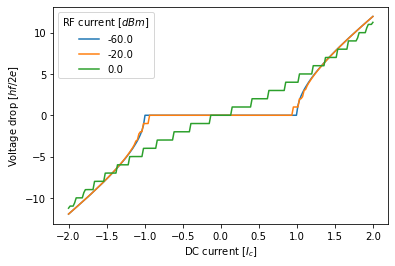

In [4]:
V.plot(hue='i_rf');

Simulation took: 3.7 s


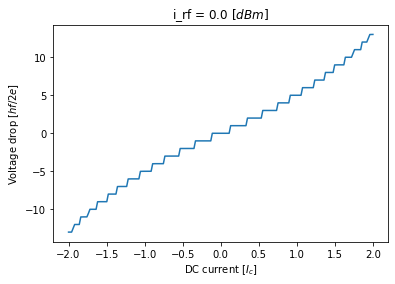

In [ ]:
I_dc = np.linspace(-2,2, 200)
I_rf = np.array([1])
V = RSJ_JJ(I_dc, I_rf, f_rf = 1.5e9, Rj = 500, Ic = 50e-9, sigma = 0.)
V.plot(hue='i_rf');

## Single Shapiro map

In [5]:
I_dc = np.linspace(-2,2, 200)
I_rf = np.logspace(-0.5,0.5,100)
V = RSJ_JJ(I_dc, I_rf, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0.)

Simulation took: 66.1 s


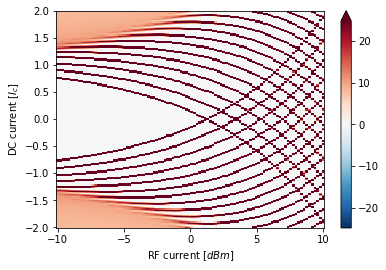

In [6]:
V.differentiate('i_dc').plot(robust=True)

## Shapiro maps for different frequencies $f_{ac}$

In [8]:
I_dc = np.linspace(-2,2, 200)
I_rf = np.logspace(-0.5, 0.5, 100)
f = np.array([1e9, 2e9, 3e9, 4e9])
V = [RSJ_JJ(I_dc, I_rf, f_rf = _f, Rj = 500, Ic = 50e-9, sigma = 0.) for _f in f]

Simulation took: 72.5 s
Simulation took: 70.0 s
Simulation took: 65.4 s
Simulation took: 63.6 s


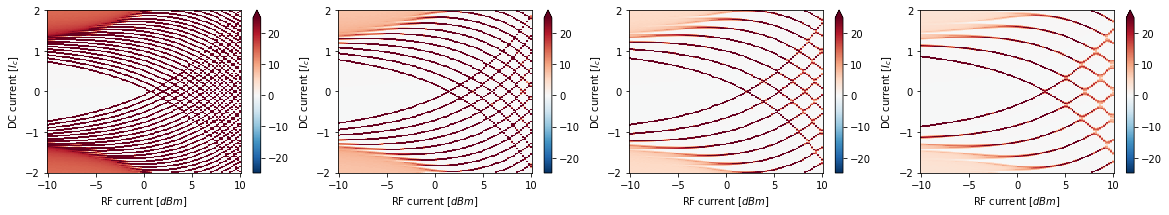

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(5*4,3))
for n in range(len(V)):
    V[n].differentiate('i_dc').plot(ax=ax[n], robust=True)

## Shapiro maps for different frequencies $f_{ac}$ and dc gaussian noise $i_N$

In [10]:
I_dc = np.linspace(-2, 2, 200)
I_rf = np.logspace(-0.5, 0.5, 100)
f = np.array([1e9, 2e9, 3e9, 4e9])
V = [RSJ_JJ(I_dc, I_rf, f_rf = _f, Rj = 500, Ic = 50e-9, sigma = 1) for _f in f]

Simulation took: 67.1 s
Simulation took: 63.9 s
Simulation took: 64.5 s
Simulation took: 63.8 s


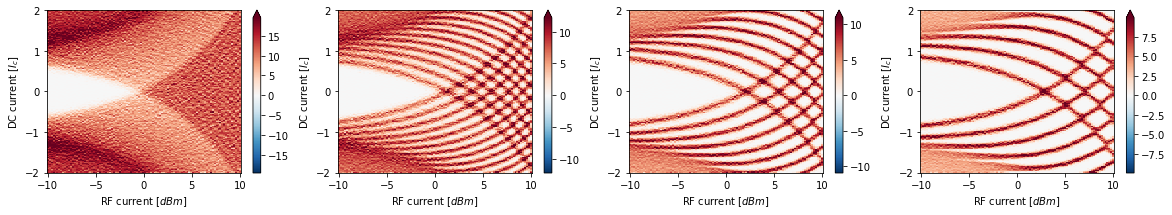

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(5*4,3))
for n in range(len(V)):
    V[n].differentiate('i_dc').plot(ax=ax[n], robust=True)

Simulation took: 0.2 s
Simulation took: 0.4 s


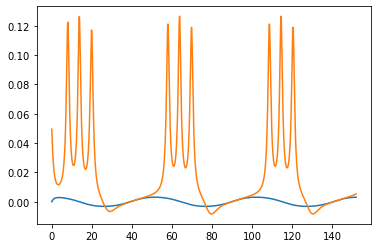

In [139]:
def RSJ_JJ(I_dc: np.array, 
           I_rf: np.array,
           f_rf: float, 
           Rj: float, 
           Ic: float, 
           sigma: float = 0.5, 
           n_periods: int = 100, 
           pts_period: int = 1000,
           phi0: float = 0) -> xr.DataArray:
    
    """
    Function that return the Shapiro map for a current biased Josephson junction with standard RSJ model.

    Args:
        I_dc : np.array, dc current bias points in units of Ic
        I_rf : np.array, ac current bias points in units of Ic
        f_rf: float, frequency of the ac component
        Rj: float, junction resistance
        sigma: std. dev of gaussian noise in units of Ic
        n_periods: number of periods to cycle in phi(t) evolution
        pts_period: number of points per cycle
        phi0: initial phase value

    Returns:
        V: xr.DataArray, voltage drop map as a function of I_dc and I_rf 
    """
    params = {'f_rf': f_rf, 'Rj': Rj, 'Ic': Ic, 'sigma': sigma, 'n_periods': n_periods, 'pts_period': pts_period}
    
    # Normalized time in units of junction plasma frequency
    t0 = hbar / ( 2 * e * Ic * Rj )
    eta = 2 * np.pi * f_rf * t0

    # Time step for the t vs phi evolution
    dt = 2 * np.pi / ( eta * pts_period )
    n_total = n_periods * pts_period

    @njit
    def CPR(phi):
        """ Return CPR of the junction """

        return np.sin(phi)

    @njit
    def Dphi(phi, t, i_dc, i_rf):
        """ Return derivative of phase """

        dphi = i_dc + i_rf * np.sin(eta * t) - CPR(phi) 
        
        return dphi

    @njit
    def RK2(phi, t, i_dc, i_rf):
        """ 4th order Runge-Kutta method for 2nd order ODE """

        F1 = Dphi(phi, t, i_dc, i_rf)
        F2 = Dphi(phi + 0.5 * dt * F1, t + 0.5 * dt, i_dc, i_rf)
        F3 = Dphi(phi + 0.5 * dt * F2, t + 0.5 * dt, i_dc, i_rf)
        F4 = Dphi(phi + dt * F3, t + dt, i_dc, i_rf)

        phi_out = phi + dt/6. * (F1 + F4 + 2.*(F2 + F3))
        t_out = t + dt

        return phi_out, t_out

    @njit
    def phase_evolution(i_dc, i_rf, phi0):
        """ Get the phase evolution for single i_dc and i_rf points. Phi0 is the initial phase value. Returns time, voltage and phase """
        
        phi, t = np.zeros(n_total), np.zeros(n_total)
        phi[0], t[0] = phi0, 0

        for n in range(n_total - 1):
            noise = random.gauss(0, sigma)
            phi[n+1], t[n+1] = RK2(phi[n], t[n], i_dc + noise, i_rf)

        return phi, t


    @njit(parallel=True)
    def loop(V, I_dc, I_rf):
        """ Loop over I_dc and I_rf that return voltage drop map """
        
        for n1 in prange(len(I_rf)):
            V[0, n1], phi0 = calculate(I_dc[0], I_rf[n1], phi0 = 0)

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0  = calculate(I_dc[n2], I_rf[n1], phi0 = phi0)

        return V * Ic * Rj / ( h * f_rf / ( 2 * e ) )

    """ Run the simulation """
    start = time.time()
            
    phi, t = phase_evolution(I_dc, I_rf, phi0 = phi0)
    
    elapsed_time = time.time() - start
    
    print(f'Simulation took: {elapsed_time:.1f} s')
    
    return np.gradient(phi), phi, t

pts_period = 1000
n_periods = 100
n_periods_plot = 3

V, phi, t = RSJ_JJ(0, 0.5, f_rf = 1.5e9, Rj = 500, Ic = 50e-9, sigma = 0., pts_period=pts_period, n_periods=n_periods)
plt.plot(t[0:n_periods_plot*pts_period],V[0:n_periods_plot*pts_period])


V, phi, t = RSJ_JJ(1, 0.5, f_rf = 1.5e9, Rj = 500, Ic = 50e-9, sigma = 0., pts_period=pts_period, n_periods=n_periods)
plt.plot(t[0:n_periods_plot*pts_period],V[0:n_periods_plot*pts_period])

In [198]:
%load_ext Cython
%%cython --pgo
cimport numpy as np
from libc.math cimport sin,pi

cdef double CPR(double phi):
    '''
        Current-phase relationship for the junction. Normally sinusoidal, can be other function for complex materials.
    '''
    return sin(phi) 

cpdef double Dphi(phi, double t, double i_dc, double i_ac, double f_rf):
    '''
        RSJ model
    '''
    dphi = -CPR(phi) + i_dc + i_ac * sin(2*pi*f_rf*t)
    return dphi 

SyntaxError: invalid syntax (3348336549.py, line 3)

In [193]:
from numba.experimental import jitclass

class RSJ_JJ:
    
    def __init__(self, 
           I_dc: np.array, 
           I_rf: np.array,
           f_rf: float, 
           Rj: float, 
           Ic: float, 
           sigma: float = 0.5, 
           n_periods: int = 100, 
           pts_period: int = 1000,
           phi0: float = 0):
        
        self.I_dc = I_dc
        self.I_rf = I_rf
        self.f_rf = f_rf
        self.Rj = Rj
        self.Ic = Ic
        self.sigma = sigma
        self.n_periods = n_periods
        self.pts_period = pts_period
        self.phi0 = phi0
        
        # Normalized time in units of junction plasma frequency
        self.t0 = hbar / ( 2 * e * self.Ic * self.Rj )
        self.eta = 2 * np.pi * self.f_rf * self.t0

        # Time step for the t vs phi evolution
        self.dt = 2 * np.pi / ( self.eta * self.pts_period )
        self.n_total = self.n_periods * self.pts_period

    def CPR(self, phi):
        """ Return CPR of the junction """

        return np.sin(phi)

    def Dphi(self, phi, t, i_dc, i_rf):
        """ Return derivative of phase """

        dphi = i_dc + i_rf * np.sin(self.eta * t) - self.CPR(phi) 
        
        return dphi

    def RK2(self, phi, t, i_dc, i_rf):
        """ 4th order Runge-Kutta method for 2nd order ODE """

        F1 = self.Dphi(phi, t, i_dc, i_rf)
        F2 = self.Dphi(phi + 0.5 * self.dt * F1, t + 0.5 * self.dt, i_dc, i_rf)
        F3 = self.Dphi(phi + 0.5 * self.dt * F2, t + 0.5 * self.dt, i_dc, i_rf)
        F4 = self.Dphi(phi + self.dt * F3, t + self.dt, i_dc, i_rf)

        phi_out = phi + self.dt/6. * (F1 + F4 + 2.*(F2 + F3))
        t_out = t + self.dt

        return phi_out, t_out

    def phase_evolution(self, i_dc, i_rf, phi0):
        """ Get the phase evolution for single i_dc and i_rf points. Phi0 is the initial phase value. Returns time, voltage and phase """
        
        phi, t = np.zeros(self.n_total), np.zeros(self.n_total)
        phi[0], t[0] = phi0, 0

        for n in range(self.n_total - 1):
            noise = random.gauss(0, self.sigma)
            phi[n+1], t[n+1] = self.RK2(phi[n], t[n], i_dc + noise, i_rf)

        return np.gradient(phi), phi, t
    
    def calculate(self, i_dc, i_rf, phi0):
        """ Calculation function for single i_dc and i_rf points. Phi0 is the initial phase value """
        phi, t = np.zeros(self.n_total), np.zeros(self.n_total)
        phi[0], t[0] = phi0, 0

        for n in range(self.n_total - 1):
            noise = random.gauss(0, self.sigma)
            phi[n+1], t[n+1] = self.RK2(phi[n], t[n], i_dc + noise, i_rf)

        return (phi[-1]-phi[0])/(t[-1]-t[0]), phi[-1]

    def loop(self, I_dc, I_rf):
        """ Loop over I_dc and I_rf that return voltage drop map """
        V = np.zeros((len(I_dc), len(I_rf)))
        for n1 in range(len(I_rf)):
            V[0, n1], phi0 = self.calculate(I_dc[0], I_rf[n1], phi0 = 0)

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0  = self.calculate(I_dc[n2], I_rf[n1], phi0 = phi0)

        return V * self.Ic * self.Rj / ( h * self.f_rf / ( 2 * e ) )

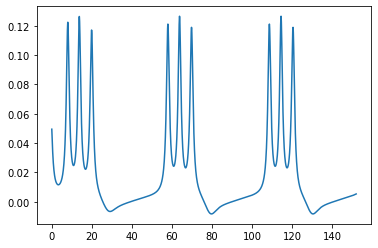

In [194]:
jj = RSJ_JJ(0, 0.5, f_rf = 1.5e9, Rj = 500, Ic = 50e-9, sigma = 0., pts_period=pts_period, n_periods=n_periods)

V, phi, t = jj.phase_evolution(1, 0.5, 0)
plt.plot(t[0:n_periods_plot*pts_period],V[0:n_periods_plot*pts_period])

In [197]:
idc = np.linspace(-1,1,11)
iac = np.linspace(-1,1,11)
V = jj.loop(idc, iac)